Using the following Script we can get the resulting dataframe with best parameters per model for each meta learner. But since this is computationally very expensive, I have already ran the script and stored the results for ease of access. so we can skip the first script and directly continue ahead.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
# load the csv file from scripts with the results of the grid search for each meta-learner
results_df_k = pd.read_csv('../../results/benchmark_data_results/grid_search_results/grid_search_results_hypothesis_k.csv')
results_df_p = pd.read_csv('../../results/benchmark_data_results/grid_search_results/grid_search_results_hypothesis_p.csv')

In [66]:
# Convert RMSE to numeric, handling missing values (R-Learner RMSE is not applicable) for hypothesis k
results_df_k['best_rmse'] = pd.to_numeric(results_df_k['best_rmse'], errors='coerce')
results_df_k['best_emse'] = pd.to_numeric(results_df_k['best_emse'], errors='coerce')

# Convert RMSE to numeric, handling missing values (R-Learner RMSE is not applicable) for hypothesis p
results_df_p['best_rmse'] = pd.to_numeric(results_df_p['best_rmse'], errors='coerce')
results_df_p['best_emse'] = pd.to_numeric(results_df_p['best_emse'], errors='coerce')

In [67]:
# Function to plot RMSE for S, T, X-Learners
def plot_rmse(results_df, hypothesis):
    # Filter out R-Learner since it doesn't have RMSE
    filtered_df = results_df[results_df['learner'] != 'R-Learner']
    plt.figure(figsize=(12, 6))
    sns.barplot(data=filtered_df, x='learner', y='best_rmse', hue='model', palette='Set2')
    plt.yscale('log')  # Apply log scale to the y-axis
    plt.title(f'Predictive Performance (RMSE) of Meta-Learners (Log Scale) for {hypothesis}')
    plt.ylabel('RMSE (Lower is Better)')
    plt.xlabel('Meta-Learner')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

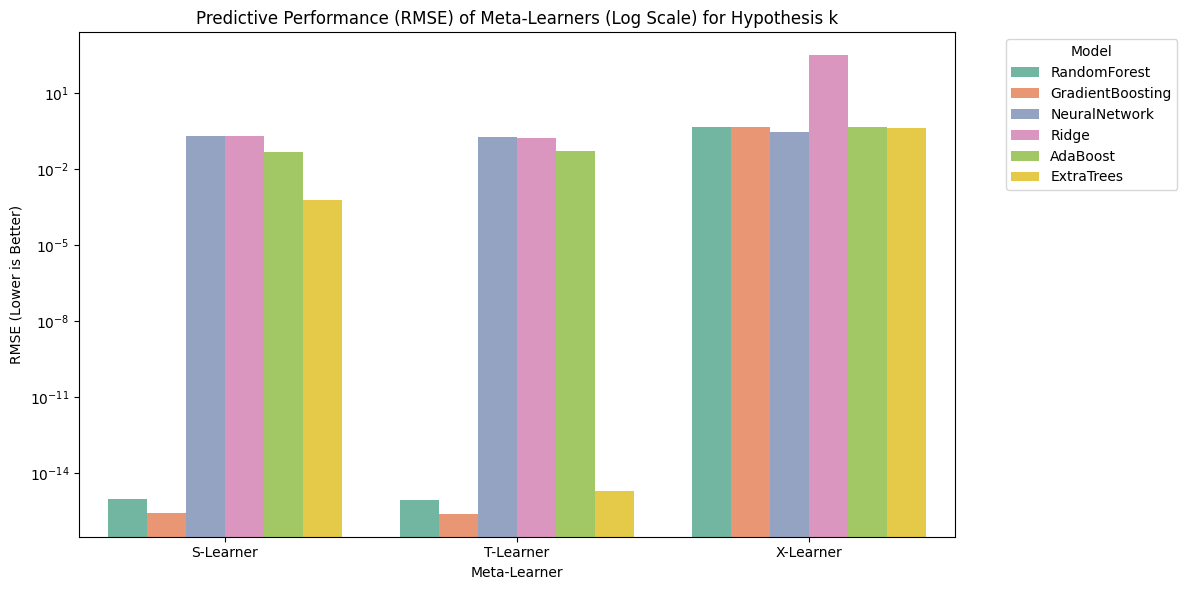

In [68]:
# Visualize RMSE for S, T, X-Learners for hypothesis k
plot_rmse(results_df_k, 'Hypothesis k')

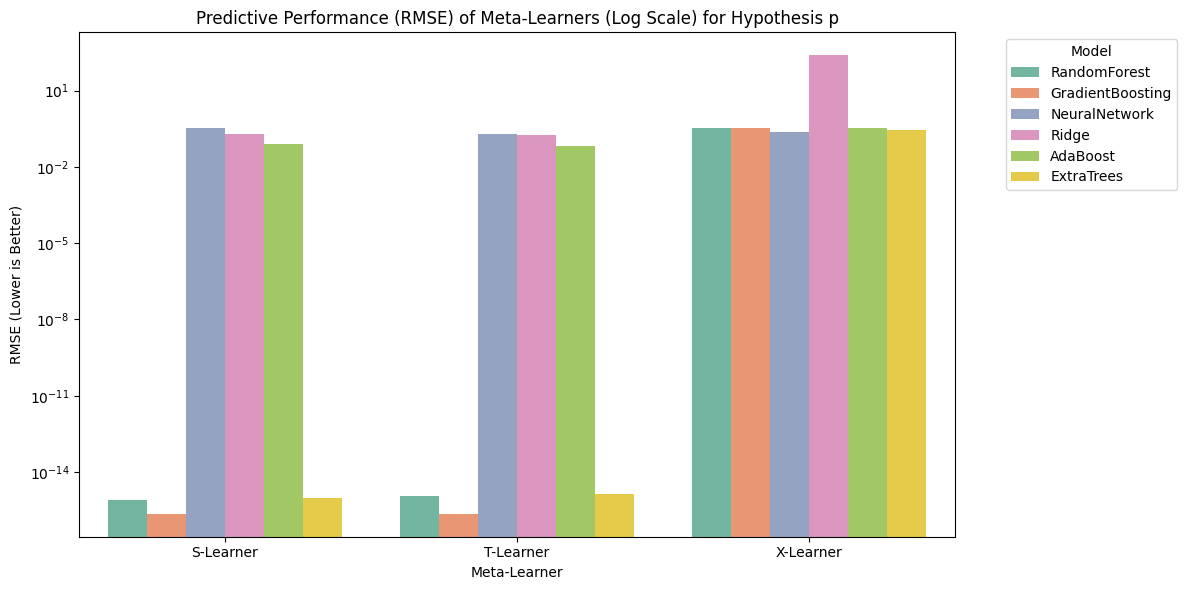

In [69]:
# Visualize RMSE for S, T, X-Learners for hypothesis p
plot_rmse(results_df_p, 'Hypothesis p')

In [70]:
# Function to plot EMSE for all meta-learners
def plot_emse(results_df, hypothesis):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='learner', y='best_emse', hue='model', palette='Set1')
    plt.yscale('log')  # Apply log scale to the y-axis
    plt.title(f'Variability of CATE Estimates (EMSE) Across Meta-Learners for {hypothesis}')
    plt.ylabel('EMSE (Lower is Better)')
    plt.xlabel('Meta-Learner')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
   

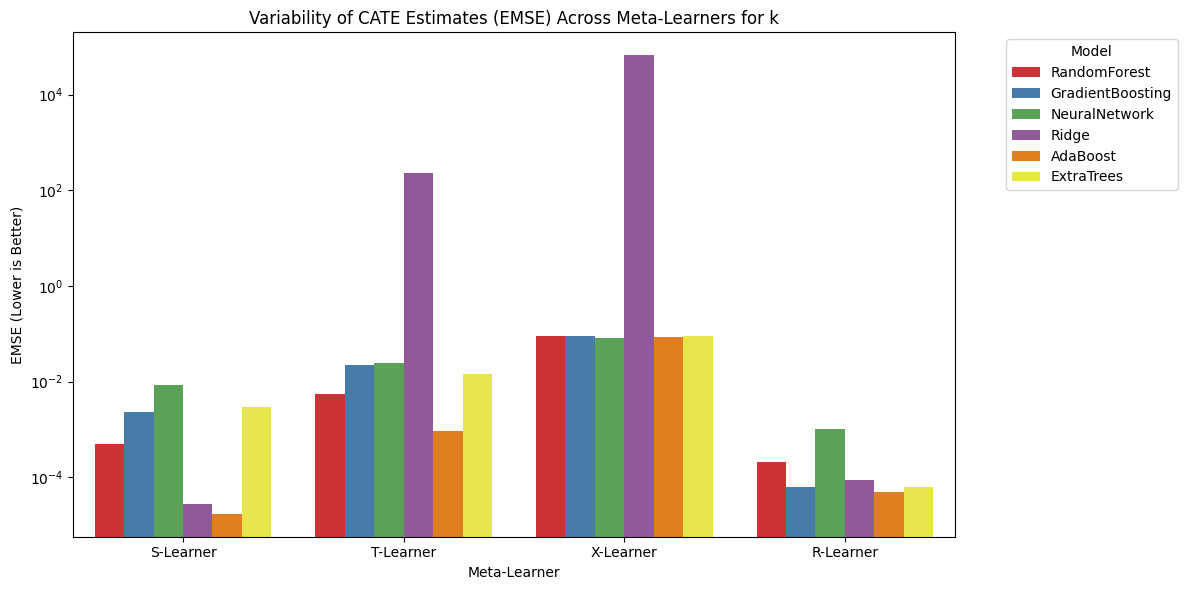

In [71]:
# Visualize EMSE for all meta-learners for hypothesis k
plot_emse(results_df_k,'k')

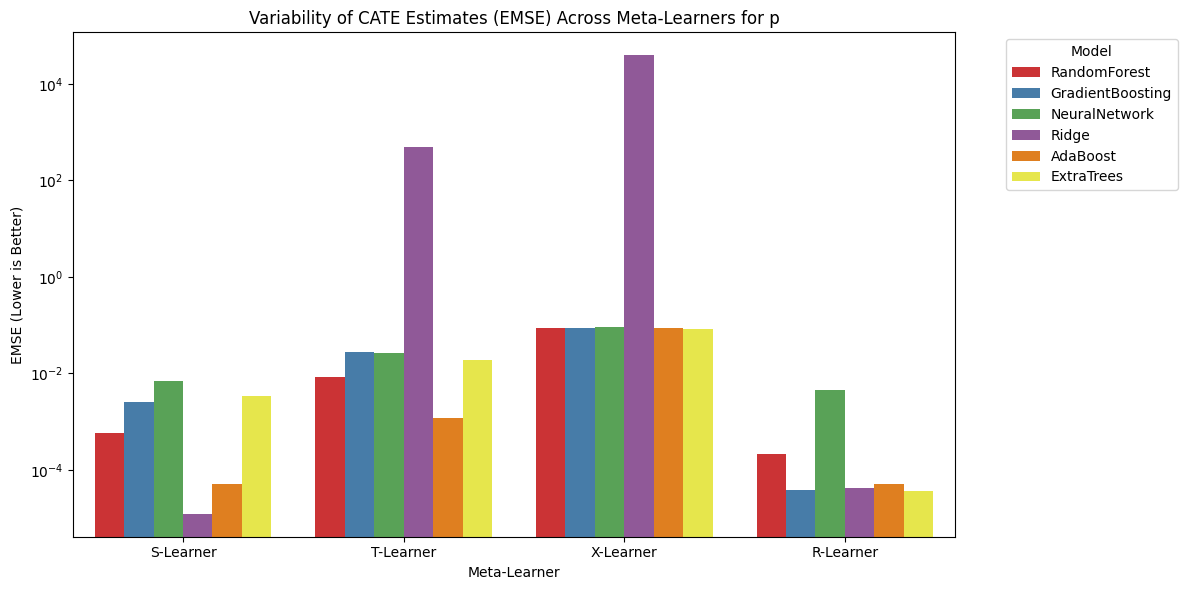

In [72]:
# Visualize EMSE for all meta-learners for hypothesis p
plot_emse(results_df_p,'p')

In [73]:
# Function to select models based on RMSE and EMSE
def select_models(results_df):
    tradeoff_models = []

    for learner in results_df['learner'].unique():
        # learner_df = results_df[results_df['learner'] == learner]
        learner_df = results_df[results_df['learner'] == learner].copy()  # Useing .copy() to avoid SettingWithCopyWarning

        
        # Best model based on EMSE
        best_emse_model = learner_df.nsmallest(1, 'best_emse')
        
        # For S, T, X-Learners, calculate tradeoff; for R-Learner, use EMSE
        if learner != 'R-Learner':
            learner_df['normalized_rmse'] = learner_df['best_rmse'] / learner_df['best_rmse'].max()
            learner_df['normalized_emse'] = learner_df['best_emse'] / learner_df['best_emse'].max()
            learner_df['tradeoff_score'] = learner_df['normalized_rmse'] + learner_df['normalized_emse']
            best_tradeoff_model = learner_df.nsmallest(1, 'tradeoff_score')
        else:
            best_tradeoff_model = best_emse_model
        
        tradeoff_models.append(best_tradeoff_model)
    tradeoff_df = pd.concat(tradeoff_models, ignore_index=True)
    
    return tradeoff_df

# Plotting tradeoff visualization
def plot_tradeoff(results_df, tradeoff_df, hypothesis):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=results_df, x='best_rmse', y='best_emse', hue='model', style='learner', palette='Set2', s=100)
    
    # Highlight selected models for tradeoff
    for _, row in tradeoff_df.iterrows():
        plt.scatter(row['best_rmse'], row['best_emse'], color='red', s=200, label=f"Selected: {row['learner']} ({row['model']})", edgecolors='black')
    plt.yscale('log')  # Apply log scale to the y-axis
    plt.title(f'Trade-off Between RMSE and EMSE for Meta-Learners for {hypothesis}')
    plt.xlabel('RMSE (Lower is Better)')
    plt.ylabel('EMSE (Lower is Better)')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


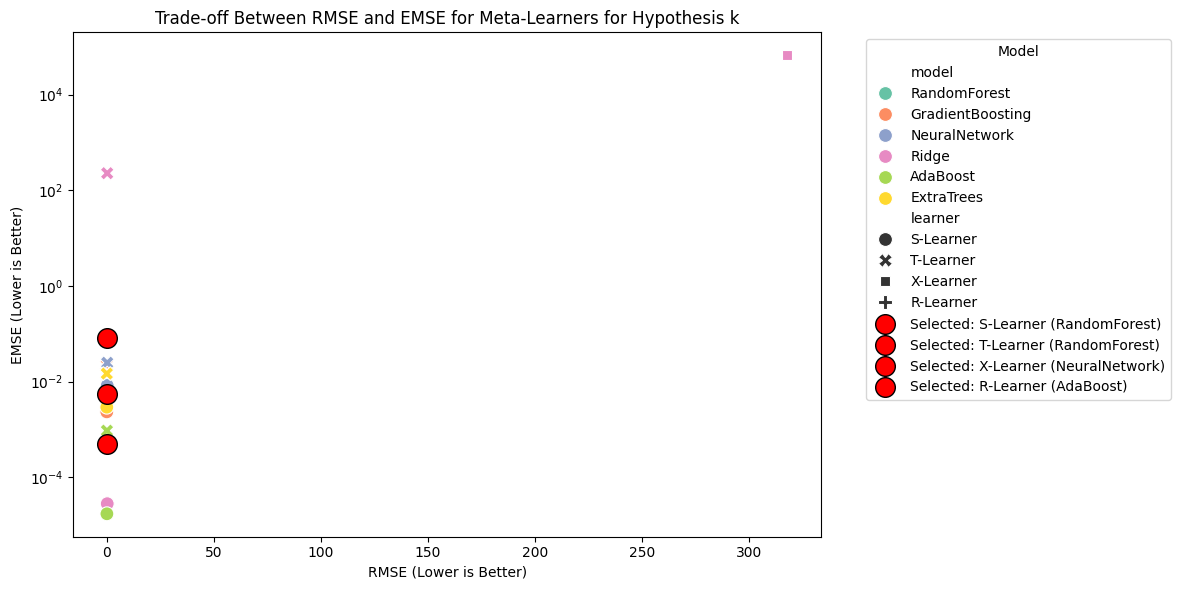

In [74]:
# Select models
tradeoff_df_k = select_models(results_df_k)
plot_tradeoff(results_df_k, tradeoff_df_k, 'Hypothesis k')

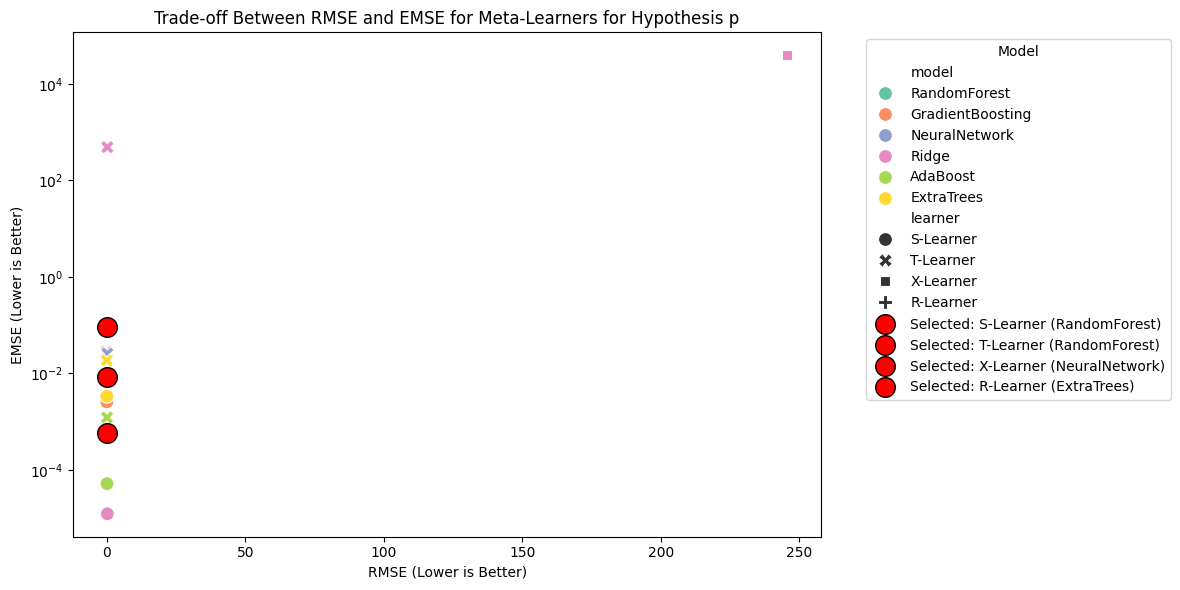

In [75]:
# Select models for hypothesis p
tradeoff_df_p = select_models(results_df_p)
plot_tradeoff(results_df_p, tradeoff_df_p, 'Hypothesis p')

In [76]:
from tabulate import tabulate

def create_selected_model_table(tradeoff_df):
    """
    Create a better-looking table showing the final selected models and their best parameters for each meta-learner.
    """
    # Extract relevant columns
    selected_models_table = tradeoff_df[['learner', 'model', 'best_params', 'best_rmse', 'best_emse']].copy()
    
    # Rename columns for better readability
    selected_models_table.rename(columns={
        'learner': 'Meta-Learner',
        'model': 'Selected Model',
        'best_params': 'Best Parameters',
        'best_rmse': 'RMSE (Lower is Better)',
        'best_emse': 'EMSE (Lower is Better)'
    }, inplace=True)

    # Convert to a list of dictionaries for tabulate
    table_data = selected_models_table.to_dict(orient='records')

    # Print the table using tabulate
    print(tabulate(
        table_data,
        headers="keys",
        tablefmt="grid",
        numalign="center",
        stralign="center"
    ))




In [77]:
# Display selected models for hypothesis k
create_selected_model_table(tradeoff_df_k)

+----------------+------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------+--------------------------+
|  Meta-Learner  |  Selected Model  |                                                                                                                                                                               Best Parameters                                                                                                                                                                               |  RMSE (Lower is Better)  |  EMSE (Lower is Better)  |
+================+==================+===============================================

In [78]:
# Display selected models for hypothesis p
create_selected_model_table(tradeoff_df_p)

+----------------+------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------+--------------------------+
|  Meta-Learner  |  Selected Model  |                                                                                                                                                                             Best Parameters                                                                                                                                                                              |  RMSE (Lower is Better)  |  EMSE (Lower is Better)  |
+================+==================+=====================================================